# Несбалансированные выборки. Практическая работа

## Цель практической работы

Научиться обрабатывать несбалансированные данные и обучать модели машинного обучения на таких данных.

## Что входит в работу


1. Загрузить данные и провести разведочный анализ.
2. Разделить данные на обучающую и тестовую выборки.
3. Подготовить данные для моделирования.
4. Сбалансировать данные методом SMOTE и обучить модель машинного обучения.
5. Обучить модель машинного обучения с использованием весов классов и кросс-валидации.
6. Сравнить метрики качества четырёх моделей.




## Что оценивается 

- Выполнены все этапы работы.
- Не допущена утечка данных при разделении выборок и подготовке данных.
- Данные корректным образом сбалансированы.
- Модели не переобучены.


## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.


# Задача

Пусть у нас имеется некоторый набор данных `german_credit_data.csv` о заёмщиках банка:

* Age — возраст заёмщика.
* Sex — пол заёмщика.
* Job — тип работы заёмщика.
* Housing — тип жилья заёмщика.
* Saving accounts — объём средств на сберегательных счетах заёмщика.
* Checking account — объём средств на основном счёте заёмщика.
* Credit amount — размер кредита. 
* Duration — срок кредита (в месяцах).
* Purpose — цель кредита.
* Risk — таргет, допустил ли заёмщик просрочку платежей по кредиту.

Решите задачу классификации заёмщиков, чтобы банк умел заранее предсказывать просрочку платежей по кредиту. 



# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [103]:
df = pd.read_csv('german_credit_data.csv')

In [104]:
# очень недобные названия
col_names = dict()
for col in df.columns:
    col_names[col] = col.replace(' ','_').lower() if ' ' in col.lower() else (col.lower()[3:] if 'num' in col.lower() else  col.lower())
df = df.rename(columns=col_names)

In [105]:
len(df)

1000

In [106]:
df.isna().sum()

age                   0
sex                   0
job                   0
housing               0
saving_accounts     183
checking_account    394
credit_amount         0
duration              0
purpose               0
risk                  0
dtype: int64

In [107]:
df.loc[df['checking_account'].isna() == True, 'checking_account'] = 'unknown'

In [108]:
df.loc[df['saving_accounts'].isna() == True, 'saving_accounts'] = 'unknown'

In [109]:
for col in df.columns:
    if df[col].dtype == 'O':
        continue

    res = stats.shapiro(df[col])
#     print(res[1] > 0.05)
    print(col,' - not normal dist' if res.pvalue <= 0.05  else '- normal dist')

age  - not normal dist
job  - not normal dist
credit_amount  - not normal dist
duration  - not normal dist


In [110]:
from sklearn.preprocessing import MinMaxScaler

In [111]:
obj_cols = []
for col in df.columns:
    if df[col].dtype == 'O':
        obj_cols.append(col)
        
obj_cols


['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose', 'risk']

In [139]:
classes = dict()
for col in obj_cols:

    encoder = LabelEncoder()
    new_name = col+'_le'
    df[new_name] = encoder.fit_transform(df[col])

    classes[col] = list(zip(df[col].value_counts().keys(), df[new_name].value_counts().keys()))
    df = df.drop(col, axis=1)

In [153]:
num_cols = []
for col in df.columns:
    if '_le' in col:
        continue
    num_cols.append(col)

In [165]:
df.risk_le.value_counts()

1    700
0    300
Name: risk_le, dtype: int64

In [164]:
classes

{'sex': [('male', 1), ('female', 0)],
 'housing': [('own', 1), ('rent', 2), ('free', 0)],
 'saving_accounts': [('little', 0),
  ('unknown', 4),
  ('moderate', 1),
  ('quite rich', 2),
  ('rich', 3)],
 'checking_account': [('unknown', 3),
  ('little', 0),
  ('moderate', 1),
  ('rich', 2)],
 'purpose': [('car', 1),
  ('radio/TV', 5),
  ('furniture/equipment', 4),
  ('business', 0),
  ('education', 3),
  ('repairs', 6),
  ('domestic appliances', 2),
  ('vacation/others', 7)],
 'risk': [('good', 1), ('bad', 0)]}

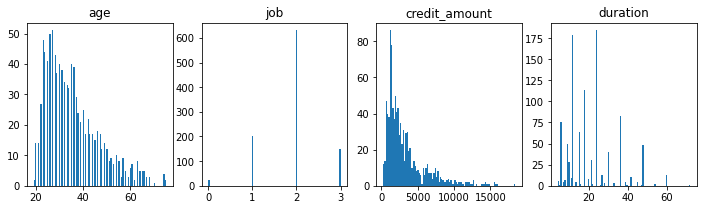

In [160]:
ax = plt.subplots(1, len(num_cols) , figsize=(12,3), )[1]
# i = 0
# k = 0
counter = 0
for col in num_cols:
    ax[counter].hist(df[col], bins=100)
    ax[counter].set_title(f'{col}')#, rotation=30)
    counter += 1


# Задание 2

Разделите датасет на обучающую и тестовую выборки в пропорции 80:20. Разделение должно быть стратифицированным по таргету Risk.

В этом и следующих заданиях используйте random_state = 1.

# Задание 3

Проведите этап очистки и подготовки данных (data preparation) и подготовьте данные к моделированию.

# Задание 4

Сбалансируйте обучающую выборку методом SMOTE и обучите модель RandomForestClassifier. Подберите оптимальные гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

# Задание 5

Обучите модель RandomForestClassifier с использованием весов классов. Подберите оптимальные веса и гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.